# Task 1: Data Understanding \& Preparation

In [131]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [132]:
import warnings 

warnings.filterwarnings('ignore')

## Loading the dataset

In [133]:
df = pd.read_csv('../dataset/customer_supermarket.csv', sep='\t', index_col=0)
df

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,01/12/10 08:26,"2,55",17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,01/12/10 08:26,"2,75",17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6
...,...,...,...,...,...,...,...,...
541905,581587,09/12/11 12:50,"2,1",12680.0,France,22899,CHILDREN'S APRON DOLLY GIRL,6
541906,581587,09/12/11 12:50,"4,15",12680.0,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4
541907,581587,09/12/11 12:50,"4,15",12680.0,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4
541908,581587,09/12/11 12:50,"4,95",12680.0,France,22138,BAKING SET 9 PIECE RETROSPOT,3


## Basic checks

In [134]:
n_samples = df.shape[0]
df.drop_duplicates(ignore_index=True, inplace=True)
duplicates = n_samples - df.shape[0]
print('Number of canceled duplicates: {}/{} ({:.2f}%)'.format(duplicates, n_samples, duplicates / n_samples * 100))

Number of canceled duplicates: 5232/471910 (1.11%)


In [135]:
df.dtypes

BasketID            object
BasketDate          object
Sale                object
CustomerID         float64
CustomerCountry     object
ProdID              object
ProdDescr           object
Qta                  int64
dtype: object

In [136]:
df['Sale'] = df['Sale'].str.replace(',', '.')
df['Sale'] = pd.to_numeric(df['Sale'])
df = df.astype({'BasketDate': 'datetime64',
                'CustomerID': 'object'})

In [137]:
df.dtypes

BasketID                   object
BasketDate         datetime64[ns]
Sale                      float64
CustomerID                 object
CustomerCountry            object
ProdID                     object
ProdDescr                  object
Qta                         int64
dtype: object

This dataset contains 8 attributes that correspond to:

- *BasketID*: a 6 digit integer number uniquely assigned to each purchase; if it starts with a *C*, it indicates a cancellation;
- *BasketDate*: the day and time when each purchase was placed;
- *Sale*: the unit product price, all in the same currency, probably in sterling;
- *CustomerID*: a 5 digit integer number uniquely assigned to each customer;
- *CustomerCountry*: the name of the country where each customer resides;
- *ProdID*: a 5 digit + 1 letter identifier uniquely assigned to each distinct product; identical codes with different letters identify the same products with different characteristics (e.g., 84997D: pink piece polkadot cutlery set - 84997C: blue piece polkadot cutlery set);
- *ProdDescr*: the description of the product purchased;
- *Qta*: the purchased quantities of each product per order.

In [138]:
pd.DataFrame([{'transactions': df['BasketID'].nunique(), 
               'customers': df['CustomerID'].nunique(), 
               'products': df['ProdID'].nunique()}], index=['quantity'])

,transactions,customers,products
quantity,24627,4372,3953


In [139]:
df.isnull().any()

BasketID           False
BasketDate         False
Sale               False
CustomerID          True
CustomerCountry    False
ProdID             False
ProdDescr           True
Qta                False
dtype: bool

In [142]:
n_samples = df.shape[0]
null_customers = df['CustomerID'].isnull().sum()
print('Number of null CustomerID(s): {}/{} ({:.2f}%)'.format(null_customers, n_samples, null_customers / n_samples * 100))
null_prod_descrs = df['ProdDescr'].isnull().sum()
print('Number of null ProdDescr(s): {}/{} ({:.2f}%)'.format(null_prod_descrs, n_samples, null_prod_descrs / n_samples * 100))

Number of null CustomerID(s): 65073/466678 (13.94%)
Number of null ProdDescr(s): 753/466678 (0.16%)


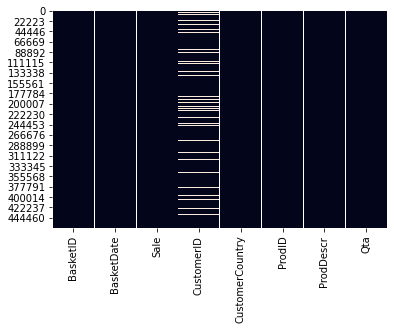

In [143]:
sns.heatmap(df.isnull(), cbar=False);

In [144]:
df.describe()

,Sale,Qta
count,466678.000000,466678.000000
mean,4.049057,10.806528
std,84.237135,232.627771
min,-11062.060000,-80995.000000
25%,1.250000,2.000000
50%,2.080000,4.000000
75%,3.750000,12.000000
max,38970.000000,80995.000000


## Data Cleaning and Integration

### Customer IDs

First of all, we are going to remove the entries for which the *CustomerID* variable is null:

In [146]:
df = df[~df['CustomerID'].isnull()]
df.reset_index(drop=True, inplace=True)
df['CustomerID'].isnull().any()

False

### Product IDs

Above, it has been seen that some values of the *ProdID* variable indicate a particular transaction (i.e., *D* for *Discount*). We check the contents of this variable by looking for the set of codes that would contain only letters:

In [147]:
special_codes = df[df['ProdID'].str.contains('^[a-zA-Z]+', regex=True)]['ProdID'].unique()
for code in special_codes:
    print("{:<15} -> {:<30}".format(code, df[df['ProdID'] == code]['ProdDescr'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
CRUK            -> CRUK Commission               


We see that there are several types of peculiar transactions, connected e.g., to *port charges* or *bank charges*.

In [148]:
df = df[~df.ProdID.isin(special_codes)]
df.reset_index(drop=True, inplace=True)
df.ProdID.isin(special_codes).any()

False

### Basket IDs

Then, we examined the existence of entries with the prefix *C* for the *BasketID* variable which indicates transactions that have been canceled since for each of those correspond a negative quantity:

In [149]:
canceled_orders = df[df['BasketID'].str.contains('C')]
canceled_orders

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
152,C536383,2010-01-12 09:49:00,4.65,15311,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
233,C536391,2010-01-12 10:24:00,1.65,17548,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
234,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
235,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24
236,C536391,2010-01-12 10:24:00,0.29,17548,United Kingdom,21980,PACK OF 12 RED RETROSPOT TISSUES,-24
...,...,...,...,...,...,...,...,...
399249,C581490,2011-09-12 09:57:00,1.95,14397,United Kingdom,22178,VICTORIAN GLASS HANGING T-LIGHT,-12
399250,C581490,2011-09-12 09:57:00,0.83,14397,United Kingdom,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11
399498,C581568,2011-09-12 11:57:00,10.95,15311,United Kingdom,21258,VICTORIAN SEWING BOX LARGE,-5
399499,C581569,2011-09-12 11:58:00,1.25,17315,United Kingdom,84978,HANGING HEART JAR T-LIGHT HOLDER,-1


In [150]:
(canceled_orders['Qta'] < 0).all()

True

We decide to create a new variable in the dataframe that indicate if part of the order has been canceled.

In [151]:
df['QtaCanc'] = 0

For the cancellations without counterparts, they are probably due to the fact that the buy orders were placed before December 2010, the point of entry of the dataset. Below, we make a census of the cancel orders and check for the existence of counterparts:

In [152]:
counterpart_entries = []
no_counterpart_entries = []

for index, col in canceled_orders.iterrows():
        
    df_test = df[(df['CustomerID'] == col['CustomerID']) & 
                 (df['ProdID'] == col['ProdID']) & 
                 (df['BasketDate'] <= col['BasketDate']) & 
                 (df['Qta'] > 0)].copy()
    
    # cancelation without a counterpart
    if df_test.shape[0] == 0:
        no_counterpart_entries.append(index)
    
    # cancelation with a counterpart
    elif df_test.shape[0] == 1:
        index_order = df_test.index[0]
        df.loc[index_order, 'QtaCanc'] = -col['Qta']
        counterpart_entries.append(index)
    
    # multiple counterparts exist: we delete the most recent
    elif df_test.shape[0] > 1:
        df_test.sort_index(ascending=False, inplace=True)
        for idx, val in df_test.iterrows():
            if val['Qta'] < -col['Qta']: 
                continue
            df.loc[idx, 'QtaCanc'] = -col['Qta']
            counterpart_entries.append(index) 
            break

In [153]:
n_canceled = canceled_orders.shape[0]
print('Number of canceled orders with a counterpart: {}/{} ({:.2f}%)'.format(
    len(counterpart_entries), n_canceled, len(counterpart_entries) / n_canceled * 100))
print('Number of canceled orders without a counterpart: {}/{} ({:.2f}%)'.format(
    len(no_counterpart_entries), n_canceled, len(no_counterpart_entries) / n_canceled * 100))

df.drop(counterpart_entries, inplace=True)
df.drop(no_counterpart_entries, inplace=True)
df.reset_index(drop=True, inplace=True)

remaining_canceled = df[df['Qta'] < 0].shape[0]
print('Number of remaining canceled orders (with counterpart orders probably placed before December 2010): {}/{} ({:.2f}%)'.format(
    remaining_canceled, n_canceled, remaining_canceled / n_canceled * 100))

Number of canceled orders with a counterpart: 6109/8506 (71.82%)
Number of canceled orders without a counterpart: 2358/8506 (27.72%)
Number of remaining canceled orders (with counterpart orders probably placed before December 2010): 39/8506 (0.46%)


In [154]:
df['Qta'] = df['Qta'] - df['QtaCanc']
df.drop('QtaCanc', axis=1, inplace=True)

In [155]:
df = df[df['Qta'] > 0]
df.reset_index(drop=True, inplace=True)
(df['Qta'] < 0).any()

False

### Customers Country

In [156]:
countries = df['CustomerCountry'].value_counts()
countries

United Kingdom          347171
Germany                   8606
France                    7972
EIRE                      7015
Spain                     2400
Netherlands               2322
Belgium                   1931
Switzerland               1808
Portugal                  1411
Australia                 1128
Norway                    1042
Channel Islands            743
Italy                      736
Finland                    647
Cyprus                     600
Sweden                     425
Austria                    384
Denmark                    365
Poland                     325
Japan                      320
Israel                     245
Unspecified                241
Singapore                  215
Iceland                    182
Canada                     150
Greece                     142
Malta                      108
United Arab Emirates        67
USA                         67
European Community          57
RSA                         57
Lebanon                     45
Lithuani

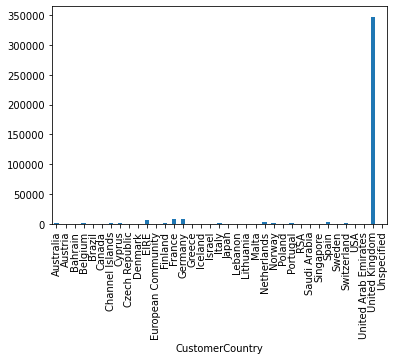

In [157]:
df['CustomerCountry'].groupby(df['CustomerCountry']).count().plot(kind='bar');

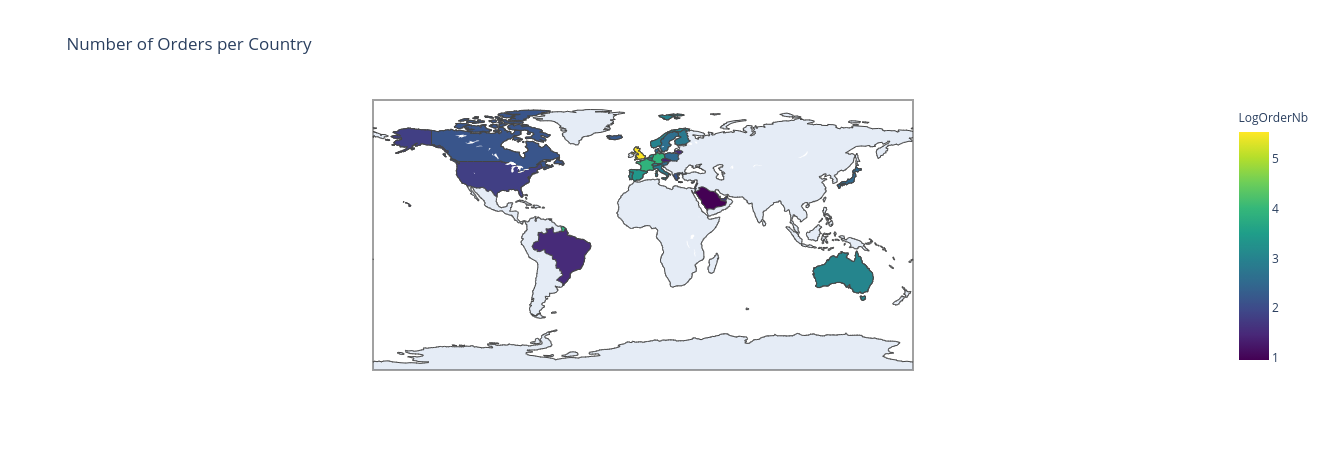

In [158]:
fig = go.Figure(
    data=go.Choropleth(
        locations=countries.index,
        z=np.log10(countries), 
        locationmode='country names', 
        colorscale='viridis',
        colorbar_title='LogOrderNb'))
fig.update_layout(title_text='Number of Orders per Country')

fig.show()

As customer clusters may vary by geography, we’ll restrict the data to only United Kingdom customers, which contains most of our customers historical data.

In [159]:
# df = df[df['CustomerCountry'] == 'United Kingdom']
# df.reset_index(drop=True, inplace=True)
# (df['CustomerCountry'] != 'United Kingdom').any()

In [160]:
df.drop('CustomerCountry', axis=1, inplace=True)

### Baskets Date

We noticed that 2010 data aren't enough representative, they are only a small fraction of the dataset and they appear to be only around the 12th of the month; in contrast 2011's data are more uniformely distributed, so we decide to keep only the latter:

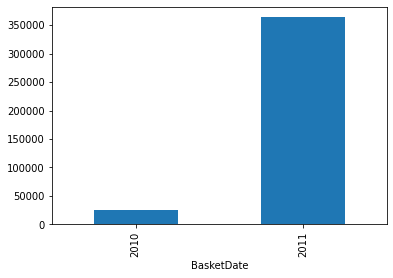

In [161]:
df['BasketDate'].groupby(df['BasketDate'].dt.year).count().plot(kind='bar');

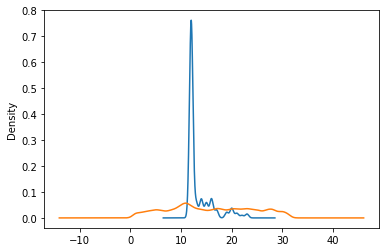

In [162]:
fig, ax = plt.subplots(1,1)
df[df['BasketDate'].dt.year == 2010]['BasketDate'].dt.day.plot(kind='kde', ax=ax);
df[df['BasketDate'].dt.year == 2011]['BasketDate'].dt.day.plot(kind='kde', ax=ax);

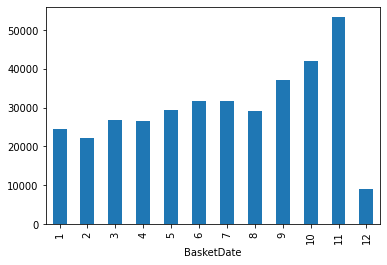

In [164]:
df['BasketDate'].groupby(df['BasketDate'].dt.month).count().plot(kind='bar');

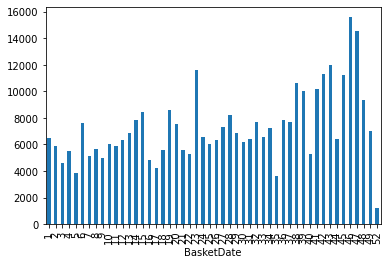

In [165]:
df['BasketDate'].groupby(df['BasketDate'].dt.week).count().plot(kind='bar');

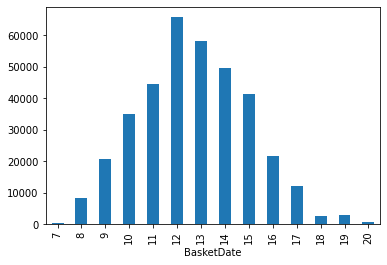

In [166]:
df['BasketDate'].groupby(df['BasketDate'].dt.hour).count().plot(kind='bar');

In [163]:
df = df[df['BasketDate'].dt.year == 2011]
df.reset_index(drop=True, inplace=True)
(df['BasketDate'].dt.year == 2010).any()

False

### Sales

In [167]:
df[df['Sale'] == 0]

,BasketID,BasketDate,Sale,CustomerID,ProdID,ProdDescr,Qta
2870,540372,2011-06-01 16:41:00,0.0,13081,22090,PAPER BUNTING RETROSPOT,24
2872,540372,2011-06-01 16:41:00,0.0,13081,22553,PLASTERS IN TIN SKULLS,24
27038,543599,2011-10-02 13:08:00,0.0,17560,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16
58261,547417,2011-03-23 10:25:00,0.0,13239,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36
65253,548318,2011-03-30 12:45:00,0.0,13113,22055,MINI CAKE STAND HANGING STRAWBERY,5
69680,548871,2011-04-04 14:42:00,0.0,14410,22162,HEART GARLAND RUSTIC PADDED,2
79303,550188,2011-04-14 18:57:00,0.0,12457,22636,CHILDS BREAKFAST SET CIRCUS PARADE,1
100358,553000,2011-12-05 15:21:00,0.0,17667,47566,PARTY BUNTING,4
108708,554037,2011-05-20 14:13:00,0.0,12415,22619,SET OF 6 SOLDIER SKITTLES,80
165091,561284,2011-07-26 12:24:00,0.0,16818,22167,OVAL WALL MIRROR DIAMANTE,1


In [168]:
df['Sale'].replace(0, np.nan, inplace=True)
df['Sale'] = df.groupby('ProdID')['Sale'].transform(lambda x: x.replace(to_replace=np.nan, value=x.mean()))
df['Sale'].isnull().any()

False

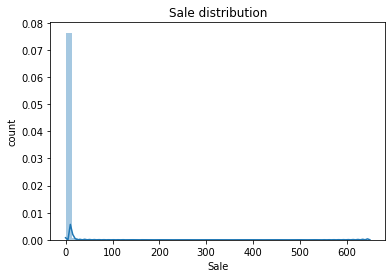

In [169]:
sns.distplot(df['Sale'])
plt.title('Sale distribution')
plt.xlabel('Sale')
plt.ylabel('count');

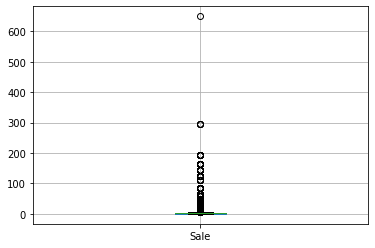

In [170]:
df.boxplot('Sale');

In [171]:
df[df['Sale'] > 200]

,BasketID,BasketDate,Sale,CustomerID,ProdID,ProdDescr,Qta
50417,546480,2011-03-14 11:38:00,295.0,13452,22656,VINTAGE BLUE KITCHEN CABINET,1
61416,547814,2011-03-25 14:19:00,295.0,13452,22656,VINTAGE BLUE KITCHEN CABINET,1
88457,551393,2011-04-28 12:22:00,295.0,14973,22656,VINTAGE BLUE KITCHEN CABINET,1
114396,554836,2011-05-26 16:25:00,295.0,13015,22655,VINTAGE RED KITCHEN CABINET,1
126617,556446,2011-10-06 15:33:00,649.5,15098,22502,PICNIC BASKET WICKER 60 PIECES,1


We can use the interquartile range method to reduce the outliers and distribution skewness:

- IQR = Q3 - Q1
- lower bound = Q1 - 1.5 * IQR
- upper bound = Q3 + 1.5 * IQR

In [ ]:
# q1 = df['Sale'].quantile(0.25)
# q3 = df['Sale'].quantile(0.75)
# iqr = q3 - q1 
# lb = q1 - 1.5 * iqr
# ub = q3 + 1.5 * iqr

# print('Q1 = {}'.format(q1))
# print('Q3 = {}'.format(q3))
# print('IQR = Q3 - Q1 = {}'.format(iqr))
# print('lower bound = Q1 - 1.5 * IQR = {}'.format(lb))
# print('upper bound = Q1 - 1.5 * IQR = {}'.format(ub))

In [ ]:
# df = df[~((df['Sale'] < lb) | (df['Sale'] > ub))]
# df

In [ ]:
# sns.distplot(df['Sale'])
# plt.title('Sale distribution')
# plt.xlabel('Sale')
# plt.ylabel('count');

In [ ]:
# df.boxplot('Sale');

### Quantities

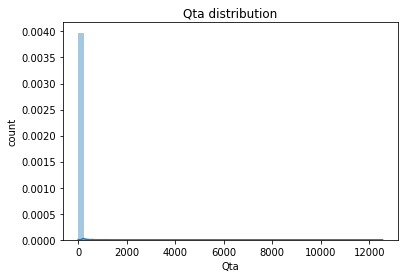

In [172]:
sns.distplot(df['Qta'])
plt.title('Qta distribution')
plt.xlabel('Qta')
plt.ylabel('count');

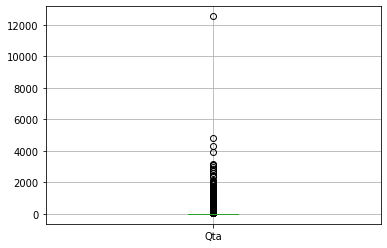

In [173]:
df.boxplot('Qta');

In [174]:
df[df['Qta'] > 3800]

,BasketID,BasketDate,Sale,CustomerID,ProdID,ProdDescr,Qta
34662,544612,2011-02-22 10:43:00,0.82,18087,22053,EMPIRE DESIGN ROSETTE,3906
114728,554868,2011-05-27 10:52:00,0.72,13135,22197,SMALL POPCORN HOLDER,4300
276220,573008,2011-10-27 12:26:00,0.21,12901,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800
336932,578841,2011-11-25 15:57:00,0.57,13256,84826,ASSTD DESIGN 3D PAPER STICKERS,12540


We can use the interquartile range method to reduce the outliers and distribution skewness:

- IQR = Q3 - Q1
- lower bound = Q1 - 1.5 * IQR
- upper bound = Q3 + 1.5 * IQR

In [192]:
# q1 = df['Qta'].quantile(0.25)
# q3 = df['Qta'].quantile(0.75)
# iqr = q3 - q1
# lb = q1 - 1.5 * iqr
# ub = q3 + 1.5 * iqr

# print('Q1 = {}'.format(q1))
# print('Q3 = {}'.format(q3))
# print('IQR = Q3 - Q1 = {}'.format(iqr))
# print('lower bound = Q1 - 1.5 * IQR = {}'.format(lb))
# print('upper bound = Q3 + 1.5 * IQR = {}'.format(ub))

In [193]:
# df = df[~((df['Qta'] < lb) | (df['Qta'] > ub))]
# df

In [194]:
# sns.distplot(df['Qta'])
# plt.title('Qta distribution')
# plt.xlabel('Qta')
# plt.ylabel('count');

In [195]:
# df.boxplot('Qta');

### Products Description

In [176]:
df['ProdDescr'].isnull().any()

False

Now we need to remove the entries corresponding to lower or mixed case *ProdDescr* variable which will be not effective for the feature extraction step since they don't represent a product description:

In [177]:
df[(df['ProdDescr'].str.islower()) | # lower case
   (~df['ProdDescr'].str.islower() & ~df['ProdDescr'].str.isupper())]['ProdDescr'].unique() # mixed case

array(['BAG 125g SWIRLY MARBLES', 'BAG 500g SWIRLY MARBLES',
       '3 TRADITIONAl BISCUIT CUTTERS  SET',
       'FRENCH BLUE METAL DOOR SIGN No', 'NUMBER TILE VINTAGE FONT No ',
       'BAG 250g SWIRLY MARBLES', 'POLYESTER FILLER PAD 40x40cm',
       'POLYESTER FILLER PAD 45x45cm', 'FOLK ART GREETING CARD,pack/12',
       'ESSENTIAL BALM 3.5g TIN IN ENVELOPE',
       'POLYESTER FILLER PAD 45x30cm', 'POLYESTER FILLER PAD 30CMx30CM',
       'NUMBER TILE COTTAGE GARDEN No', 'POLYESTER FILLER PAD 65CMx65CM',
       'POLYESTER FILLER PAD 60x40cm', 'FLOWERS HANDBAG blue and orange',
       'Next Day Carriage', 'THE KING GIFT BAG 25x24x12cm',
       'High Resolution Image'], dtype=object)

In [178]:
df['ProdDescr'] = df['ProdDescr'].str.replace('[^\w\s]', '') # removing non-word chars (+, -, /, etc.) but leaving spaces
df['ProdDescr'] = df['ProdDescr'].str.replace('[0-9]+[a-zA-Z]*', '') # removing words containing numbers

df['ProdDescr'] = df['ProdDescr'].apply(lambda descr: ' '.join(descr.split())) # removing multiple whitespaces

# adjusting specific errors
df['ProdDescr'] = df['ProdDescr'].str.replace('No', '') # removing 'No'
df['ProdDescr'].replace({'TRADITIONAl BISCUIT CUTTERS SET': 'TRADITIONAl BISCUIT CUTTERS SET'.upper()}, inplace=True)
df['ProdDescr'].replace({'FLOWERS HANDBAG blue and orange': 'FLOWERS HANDBAG blue and orange'.upper()}, inplace=True)
df['ProdDescr'].replace({'FOLK ART GREETING CARDpack': 'FOLK ART GREETING CARD'}, inplace=True)

bad_descr = df[(df['ProdDescr'].str.islower()) | # lower case
               (~df['ProdDescr'].str.islower() & ~df['ProdDescr'].str.isupper())]['ProdDescr'].unique() # mixed case
bad_descr

array(['Next Day Carriage', 'High Resolution Image'], dtype=object)

In [179]:
df = df[~df['ProdDescr'].isin(bad_descr)]
df.reset_index(drop=True, inplace=True)
df['ProdDescr'].isin(bad_descr).any()

False

## Data Correlation

In [180]:
df['TotSale'] = df['Qta'] * df['Sale']

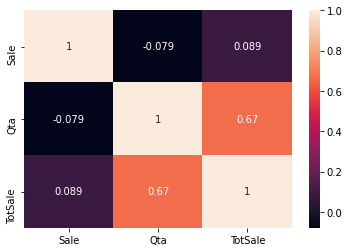

In [182]:
sns.heatmap(df.corr(), annot=True);

## Saving the new dataset

In [183]:
df.to_csv('../dataset/new_customer_supermarket.csv', sep='\t', float_format='%.2f')